In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pylab as py

import jax


def mplot(fign, x, y, xl, yl, clr, lbl):
    py.figure(fign)
    py.xlabel(xl)
    py.ylabel(yl)
    return py.plot(x, y, clr, linewidth=1.0, label=lbl)

x is a 3-by-2 array that represents the coordinates (in the plane) of three particles.

Defining the gravitational potential energy between three objects, one can then calculate the force on a particle by taking the gradient of the potential.Defining the gravitational potential energy between three objects, one can then calculate the force on a particle by taking the gradient of the potential

In [2]:
def gravEnergy(x, m1, m2, m3):
    i, j = jnp.triu_indices(3, k=1)
    r_ee = jnp.linalg.norm(
        (jnp.reshape(x, (3, 1, 2)) - jnp.reshape(x, (1, 3, 2)))[i, j], axis=-1
    )
    return -jnp.sum(jnp.array([m1 * m2, m1 * m3, m2 * m3]) / r_ee)


grad_fn = jax.grad(gravEnergy)

Compute the evolution of the system in the near future.

In [3]:
def evol(pos, vel, tstep, step):
    for i in range(0, 5 * step):
        pos = pos + vel * tstep / 5
        vel = vel - grad_fn(pos, m1, m2, m3) * tstep / 5
    return pos, vel

Consider the periodic orbit of the simplest system consisting of particles with equal masses.

https://numericaltank.sjtu.edu.cn/three-body/three-body-movies.htm

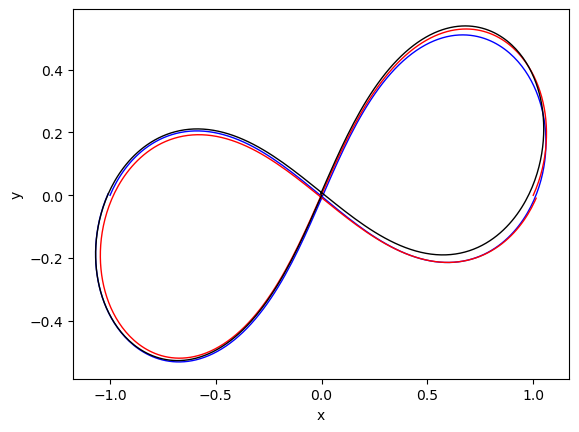

In [4]:
m1 = 1
m2 = 1
m3 = 1

v1 = 0.3471168881
v2 = 0.5327249454

xini = jnp.array([[-1.0, 0], [1, 0], [0, 0]])
vini = jnp.array([[v1, v2], [v1, v2], [-2 * v1, -2 * v2]])

time = 6.37
tstep = 0.02

num = int(time / tstep)
pos = xini
vel = vini
for i in range(0, num):
    xini = xini + vini * tstep
    vini = vini - grad_fn(xini, m1, m2, m3) * tstep

    pos = jnp.append(pos, xini)
    vel = jnp.append(vel, vini)


pos = np.resize(pos, (num + 1, 3, 2))
vel = np.resize(vel, (num + 1, 3, 2))


mplot(1, pos[:, 0, 0], pos[:, 0, 1], "x", "y", "blue", "1")
mplot(1, pos[:, 1, 0], pos[:, 1, 1], "x", "y", "red", "2")
mplot(1, pos[:, 2, 0], pos[:, 2, 1], "x", "y", "black", "3")

In most cases, the orbit is not closed. To make the orbit closed, one can asymptotically compensate for the difference between the starting and ending points, although it may not be entirely reasonable

In [5]:
errpos = np.reshape(
    np.outer(
        np.linspace(-0.5, 0.5, np.shape(pos)[0] + 1), pos[0, :, :] - pos[-1, :, :]
    ),
    (np.shape(pos)[0] + 1, 3, 2),
)
errvel = np.reshape(
    np.outer(
        np.linspace(-0.5, 0.5, np.shape(vel)[0] + 1), vel[0, :, :] - vel[-1, :, :]
    ),
    (np.shape(vel)[0] + 1, 3, 2),
)

npos = pos + errpos[0:-1, :, :]
nvel = vel + errvel[0:-1, :, :]

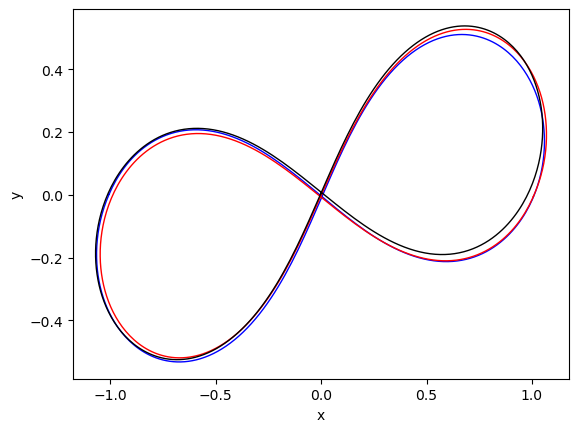

In [6]:
mplot(1, npos[:, 0, 0], npos[:, 0, 1], "x", "y", "blue", "1")
mplot(1, npos[:, 1, 0], npos[:, 1, 1], "x", "y", "red", "2")
mplot(1, npos[:, 2, 0], npos[:, 2, 1], "x", "y", "black", "3")

Let all phase points on the closed orbit evolve independently for a period of time, and then calculate the differences from the original state.

If the orbit is indeed a stable orbit, the state after evolution should be identical to the initial state.

Here, we only use the Euclidean distance between phase points to measure the difference between the orbits before and after evolution

In [7]:
step = 2


@jax.jit
def loss(para):
    pos, vel = para
    npos, nvel = jax.vmap(evol, (0, 0, None, None))(pos, vel, tstep, step)
    npos = jnp.roll(npos, (step, 0, 0), axis=0)
    nvel = jnp.roll(nvel, (step, 0, 0), axis=0)
    return jnp.sum((pos - npos) ** 2 + (vel - nvel) ** 2)


@jax.jit
def update(params, learning_rate):
    grads = jax.grad(loss)(params)
    return params[0] - grads[0] * learning_rate, params[1] - grads[1] * learning_rate

In [8]:
# for i in range(0, 20):
#     pos, vel = update((pos, vel), 0.1)
#     print(loss((pos, vel)))

for i in range(0, 20):
    npos, nvel = update((npos, nvel), 0.1)
    print(loss((npos, nvel)))

0.0049320683
0.004253029
0.0038907449
0.0036357595
0.0034339954
0.0032644393
0.0031168496
0.0029854458
0.0028666216
0.0027579567
0.00265776
0.002564766
0.0024780408
0.0023967624
0.0023203779
0.0022483626
0.0021802885
0.0021157912
0.002054575
0.0019963626


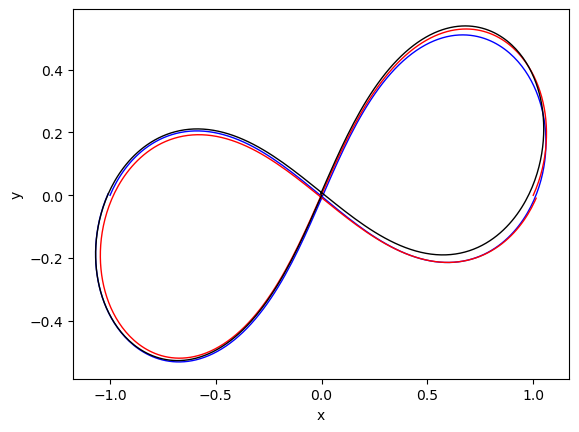

In [9]:
# mplot(1, npos[:, 0, 0], npos[:, 0, 1], "x", "y", "blue", "1")
# mplot(1, npos[:, 1, 0], npos[:, 1, 1], "x", "y", "red", "2")
# mplot(1, npos[:, 2, 0], npos[:, 2, 1], "x", "y", "black", "3")
mplot(1, pos[:, 0, 0], pos[:, 0, 1], "x", "y", "blue", "1")
mplot(1, pos[:, 1, 0], pos[:, 1, 1], "x", "y", "red", "2")
mplot(1, pos[:, 2, 0], pos[:, 2, 1], "x", "y", "black", "3")

It can be seen that the loss function is indeed decreasing, but from the graph, it is not clear whether the orbits are tending towards convergence.

The three-body problem is very sensitive to initial conditions, and by slightly perturbing the initial values, one can obtain results that deviate further from the stable orbit. However, it is also difficult to use optimization to make the orbits converge